# scraping

In [1]:
import pandas as pd

In [2]:
import requests
import bs4

In [3]:
def get_years():
    url = 'http://www.nwac.us/avalanche-forecast/archives/'
    r = requests.get(url)
    soup = bs4.BeautifulSoup(r.text, 'html5lib')
    dropdown = soup.find('select', attrs={'name': 'year'})
    years = [obj.attrs['value'] for obj in dropdown.findAll('option')]
    return years

In [4]:
get_years()

['2015', '2014', '2013', '2016']

In [5]:
def get_months(year):
    fmt = 'http://www.nwac.us/avalanche-forecast/archives/months/?year={year}'
    r = requests.get(fmt.format(year=year))
    soup = bs4.BeautifulSoup(r.text, 'html5lib')
    dropdown = soup.find('select', attrs={'name': 'month'})
    months = [obj.attrs['value'] for obj in dropdown.findAll('option')]
    return months

In [6]:
get_months(2015)

['December', 'October', 'June', 'April', 'March', 'February', 'January']

In [7]:
import re
renum = re.compile(r'\d+')

def get_forecast_list(month, year):
    fmt = 'http://www.nwac.us/avalanche-forecast/archives/days/?month={month}&year={year}'
    r = requests.get(fmt.format(year=year, month=month))
    soup = bs4.BeautifulSoup(r.text, 'html5lib')
    main = soup.find('div', attrs={'id': 'main-content'})
    links = main.findAll('a')
    results = []
    for link in links:
        url = link.attrs['href']
        forecast_id = int(renum.search(url).group(0))
        date = str(link.contents[0].lstrip())
        results.append((date,forecast_id))
    return results

In [8]:
get_forecast_list('January', '2016')

[('Jan. 27, 2016', 492),
 ('Jan. 26, 2016', 491),
 ('Jan. 25, 2016', 490),
 ('Jan. 24, 2016', 489),
 ('Jan. 23, 2016', 488),
 ('Jan. 22, 2016', 487),
 ('Jan. 21, 2016', 486),
 ('Jan. 21, 2016', 485),
 ('Jan. 21, 2016', 484),
 ('Jan. 20, 2016', 483),
 ('Jan. 19, 2016', 482),
 ('Jan. 18, 2016', 481),
 ('Jan. 17, 2016', 480),
 ('Jan. 16, 2016', 479),
 ('Jan. 15, 2016', 478),
 ('Jan. 15, 2016', 477),
 ('Jan. 14, 2016', 476),
 ('Jan. 13, 2016', 475),
 ('Jan. 12, 2016', 474),
 ('Jan. 12, 2016', 473),
 ('Jan. 11, 2016', 472),
 ('Jan. 10, 2016', 471),
 ('Jan. 9, 2016', 470),
 ('Jan. 8, 2016', 469),
 ('Jan. 7, 2016', 468),
 ('Jan. 6, 2016', 467),
 ('Jan. 5, 2016', 466),
 ('Jan. 4, 2016', 465),
 ('Jan. 4, 2016', 464),
 ('Jan. 3, 2016', 463),
 ('Jan. 2, 2016', 462),
 ('Jan. 1, 2016', 461)]

# Forecasts

In [59]:
#this is for shortening
region_names = [('Olympics', 'olympics'),
                  ('West Slopes North - Canadian Border to Skagit River', 'west-north'),
                  ('West Slopes Central - Skagit River to South of I-90', 'west-central'),
                  ('West Slopes South - South of I-90 to Columbia River', 'west-south'),
                  ('Stevens Pass', 'stevens'),
                  ('Snoqualmie Pass', 'snoqualmie'),
                  ('East Slopes North - Canadian Border to Lake Chelan', 'east-north'),
                  ('East Slopes Central - Lake Chelan to South of I-90', 'east-central'),
                  ('East Slopes South - South of I-90 to Columbia River', 'east-south'),
                  ('Mt Hood', 'hood')]

regions = [n for _,n in region_names]

region_dict = dict(region_names)

In [60]:
def trim(string, lead):
    assert string[:len(lead)] == lead
    return string[len(lead):]

def get_forecast(forecast_id):
    fmt = 'http://www.nwac.us/avalanche-forecast/avalanche-forecast/{num}/'
    r = requests.get(fmt.format(num=forecast_id))
    soup = bs4.BeautifulSoup(r.text, 'html5lib')

    date = str(soup.find('div', attrs={'class': 'forecast-date'}).contents[0].strip())
    author = str(soup.find('div', attrs={'class': 'forecaster'}).contents[0].strip())
    forecasts = soup.findAll('a', attrs={'class': 'forecast'})
    
    results = []
    for forecast in forecasts:
        region = str(forecast.find('span').contents[0].strip())
        url = forecast.attrs['href']
        subforecast_id = int(renum.search(url).group(0))
        results.append((region, subforecast_id))
    
    return trim(date, 'Issued: '), trim(author, 'by '), results

In the archive, note that frequently all east-side regions link to the same report:

In [61]:
get_forecast(274)

('6:38 AM PST Tuesday, December 23, 2014',
 'Garth Ferber',
 [('Olympics', 921),
  ('West Slopes North - Canadian Border to Skagit River', 922),
  ('West Slopes Central - Skagit River to South of I-90', 923),
  ('West Slopes South - South of I-90 to Columbia River', 923),
  ('Stevens Pass', 923),
  ('Snoqualmie Pass', 923),
  ('East Slopes North - Canadian Border to Lake Chelan', 924),
  ('East Slopes Central - Lake Chelan to South of I-90', 924),
  ('East Slopes South - South of I-90 to Columbia River', 925),
  ('Mt Hood', 926)])

In [62]:
get_forecast(486)

('7:57 AM PST Thursday, January 21, 2016',
 "Dennis D'Amico",
 [('Olympics', 1966),
  ('West Slopes North - Canadian Border to Skagit River', 1967),
  ('West Slopes Central - Skagit River to South of I-90', 1968),
  ('West Slopes South - South of I-90 to Columbia River', 1968),
  ('Stevens Pass', 1968),
  ('Snoqualmie Pass', 1968),
  ('East Slopes North - Canadian Border to Lake Chelan', 1969),
  ('East Slopes Central - Lake Chelan to South of I-90', 1970),
  ('East Slopes South - South of I-90 to Columbia River', 1970),
  ('Mt Hood', 1971)])

In [63]:
get_forecast(461)

('6:00 PM PST Thursday, December 31, 2015',
 "Dennis D'Amico",
 [('Olympics', 1850),
  ('West Slopes North - Canadian Border to Skagit River', 1851),
  ('West Slopes Central - Skagit River to South of I-90', 1851),
  ('West Slopes South - South of I-90 to Columbia River', 1851),
  ('Stevens Pass', 1851),
  ('Snoqualmie Pass', 1851),
  ('East Slopes North - Canadian Border to Lake Chelan', 1852),
  ('East Slopes Central - Lake Chelan to South of I-90', 1852),
  ('East Slopes South - South of I-90 to Columbia River', 1852),
  ('Mt Hood', 1853)])

In [64]:
get_forecast(37)

('2:36 PM PST Tuesday, December 10, 2013',
 'Kenny Kramer',
 [('Olympics', 73),
  ('Stevens Pass', 73),
  ('Snoqualmie Pass', 73),
  ('Mt Hood', 73),
  ('White Pass', 73),
  ('WA Cascades near and west of crest - between Snoqualmie and White Pass',
   73),
  ('East slopes WA Cascades - between Stevens and Snoqualmie Pass', 73),
  ('WA Cascades near and west of crest - north of Stevens Pass', 73),
  ('WA Cascades near and west of crest - south of White Pass', 73),
  ('East slopes WA Cascades - between Snoqualmie and White Pass', 73),
  ('WA Cascades near and west of crest - between Stevens and Snoqualmie Pass',
   73),
  ('East slopes WA Cascades - north of Stevens Pass', 73),
  ('East slopes WA Cascades - south of White Pass', 73)])

test date string conversion. it puts it in UTC for us

In [14]:
_[0]

'6:00 PM PST Thursday, December 31, 2015'

In [15]:
#pandas.to_datetime(_, utc=True)
pd.to_datetime(_)

Timestamp('2016-01-01 02:00:00')

old stuff

In [ ]:
def get_region_row(day):
    date, author, regions = get_forecast(day)
    utc = pd.to_datetime(date)
    #return [('id', day), ('date_utc', utc), ('author', author)] + regions
    return dict(id=day, date_utc=utc, author=author, **dict(regions))

In [ ]:
get_region_row(461)

In [ ]:
cols = ['id', 'date_utc', 'author'] + regions

def gen_report_rows(days):
    for _,day in days:
        yield get_region_row(day)

In [ ]:
df = pandas.DataFrame(list(gen_report_rows(get_forecast_list('January', '2016'))), columns=cols)
df

In [ ]:
df = df.reset_index().set_index('id')
df.head()

In [ ]:
df.to_sql('region_index', engine, if_exists='replace', index='True')

In [ ]:
df.to_sql?

In [ ]:
len(df)

# Reports

A forecast contains multiple reports, each individualized to a geographic sub-region of the NWAC forecast area.

In [244]:
def get_report(subforecast_id):
    fmt = 'http://www.nwac.us/avalanche-forecast/avalanche-region-forecast/{num}/'
    r = requests.get(fmt.format(num=subforecast_id))
    soup = bs4.BeautifulSoup(r.text, 'html5lib')

    date = str(soup.find('div', attrs={'class': 'forecast-date'}).contents[0].strip())
    author = str(soup.find('div', attrs={'class': 'forecaster'}).contents[0].strip())
    region = str(soup.find('h2').contents[0].strip())
    
    summary = soup.find('div', attrs={'class': 'forecast-summary'})
    if summary is None:
        summary = soup.find('div', attrs={'class': 'special-header-notes'})
    summary = str(summary.text).strip().replace(u'\xa0', u' ')
    
    areas = ['treeline-above',
             'treeline-near',
             'treeline-below']
    
    ratings = []
    for area in areas:
        rating = find_rating(soup, area)
        ratings.append((area, rating))
    
    return trim(date, 'Issued: '), trim(author, 'by '), region, summary, ratings

def find_rating(soup, area):
    chunk = soup.find('div', attrs={'id': area})
    if chunk is None:
        return None
    rating = chunk.find(
        'div', attrs={'class': 'elev-day1-column'}
            ).find(
        'div', attrs={'class': 'danger-description'}
            ).find('h4').contents[0]
    return str(rating)

In [245]:
get_report(1852)

('6:00 PM PST Thursday, December 31, 2015',
 "Dennis D'Amico",
 'East Slopes North - Canadian Border to Lake Chelan',
 'Watch for isolated areas of wind slab primarily on north through southeast aspects above treeline and for small loose avalanches near terrain traps on steeper slopes throughout the terrain.',
 [('treeline-above', 'Moderate'),
  ('treeline-near', 'Low'),
  ('treeline-below', 'Low')])

In [246]:
get_report(884)

('10:11 AM PST Monday, June 2, 2014',
 'Kenny Kramer',
 'Olympics',
 'Have a safe and enjoyable rest of the spring and we look forward to bringing you even better mountain weather and avalanche forecasts next season! A big thanks to all who help in supporting the Northwest Avalanche Center.  \n\nPlease note that regularly scheduled mountain weather and avalanche forecasts for the past winter season have ended.  However, weather and snow conditions will continue to be monitored through mid-June at the Northwest Weather and Avalanche Center with the information that remains available.  Additional forecasts or special statements will be issued when unusually severe avalanche conditions develop.  When issued such forecasts will be available on the NWAC Web site.',
 [('treeline-above', None), ('treeline-near', None), ('treeline-below', None)])

# Database schema

Organized storage for forecasts and reports, as well as a join table to say which go with which

In [19]:
import sqlalchemy as sa

In [20]:
engine = sa.create_engine('postgres://%s@localhost/%s'%('tkb','avy'))
print(engine.url)

postgres://tkb@localhost/avy


In [146]:
metadata = sa.MetaData()

forecast_table = sa.Table('forecasts', metadata,
                          sa.Column('forecast_id', sa.Integer,
                                    primary_key=True, autoincrement=False),
                          sa.Column('date', sa.Text),
                          sa.Column('datetime', sa.Text),
                          sa.Column('datetime_utc', sa.Time),
                          sa.Column('author', sa.Text),
                         )

report_table = sa.Table('reports', metadata,
                        sa.Column('report_id', sa.Integer,
                                  primary_key=True, autoincrement=False),
                          sa.Column('datetime', sa.Text),
                          sa.Column('datetime_utc', sa.DateTime),
                          sa.Column('author', sa.Text),
                          sa.Column('region', sa.Text),
                          sa.Column('summary', sa.Text),
                          sa.Column('treeline_above', sa.Text),
                          sa.Column('treeline_near', sa.Text),
                          sa.Column('treeline_below', sa.Text),
                        )

region_index = sa.Table('region_index', metadata,
                        sa.Column('forecast_id', sa.Integer, primary_key=True),
                        sa.Column('region', sa.Text, primary_key=True),
                        sa.Column('report_id', sa.Integer)
                       )

In [147]:
#report_table.create(engine)

In [22]:
import sqlalchemy_utils as sau

In [35]:
#sau.drop_database(engine.url)
print(sau.database_exists(engine.url))

False


In [36]:
## create a database (if it doesn't exist)
if not sau.database_exists(engine.url):
    sau.create_database(engine.url)
    metadata.create_all(engine)
print(sau.database_exists(engine.url))


True


Feed in an example row

In [ ]:
str(forecast_table.insert())

In [ ]:
str(forecast_table.insert().values())

In [ ]:
str(forecast_table.select('*'))

In [37]:
with engine.begin() as conn:
    print (conn.closed)
    pass
print (conn.closed)

False
True


# read in preliminary data.

to empty it, do TRUNCATE TABLE

Insert all in one statement. If there's a problem with any one row, this whole thing fails

In [38]:
def insert_forecasts_prelim(days):
    with engine.begin() as conn:
        data = [{'forecast_id': fid, 'date': date} for date,fid in days]
        stmt = forecast_table.insert().values(data)
        conn.execute(stmt)

batched queries. Depending on how these loops are nested, only individual things fail

In [39]:
def insert_forecasts_prelim_batched(days):
    for date,forecast_id in days:
        with engine.begin() as conn:
            stmt = forecast_table.insert().values(date=date, forecast_id=forecast_id)
            conn.execute(stmt)

for testing:

In [53]:
days = get_forecast_list('January', 2016)
#insert_forecasts_prelim(days)

# get list of all forecasts ever

and put this in the database as preliminary datas

In [54]:
def gen_all_reports():
    for year in get_years():
        for month in get_months(year):
            yield from get_forecast_list(month, year)

In [55]:
insert_forecasts_prelim(gen_all_reports())

In [56]:
pd.read_sql_query('select * from forecasts order by forecast_id limit 5', engine)

,forecast_id,date,datetime,datetime_utc,author
0,37,"Dec. 11, 2013",None,None,None
1,38,"Dec. 11, 2013",None,None,None
2,39,"Dec. 11, 2013",None,None,None
3,40,"Dec. 12, 2013",None,None,None
4,47,"Dec. 13, 2013",None,None,None


# Add region data

In [104]:
def load_forecast(forecast_id):
    datetime,author,reg_index = get_forecast(forecast_id)
    datetime_utc = pd.to_datetime(datetime)
    values = dict(datetime=datetime, author=author, datetime_utc=datetime_utc)
    
    with engine.begin() as conn:
        # fill in the rest of the forecast info (update one row)
        stmt = forecast_table.update().where(
                   forecast_table.c.forecast_id==forecast_id
                   ).values(**values)
        conn.execute(stmt)

        # populate the region index (many rows)
        data = [{'region': reg, 'report_id': rid, 'forecast_id': forecast_id} for reg,rid in reg_index]
        stmt2 = region_index.insert().values(data)
        conn.execute(stmt2)

In [113]:
load_forecast(37)

In [114]:
pd.read_sql_query('select * from forecasts order by forecast_id limit 5', engine)

,forecast_id,date,datetime,datetime_utc,author
0,37,"Dec. 11, 2013","2:36 PM PST Tuesday, December 10, 2013",22:36:00,Kenny Kramer
1,38,"Dec. 11, 2013",None,None,None
2,39,"Dec. 11, 2013",None,None,None
3,40,"Dec. 12, 2013",None,None,None
4,47,"Dec. 13, 2013",None,None,None


In [115]:
pd.read_sql_query('select * from region_index', engine)

,forecast_id,region,report_id
0,37,Olympics,73
1,37,Stevens Pass,73
2,37,Snoqualmie Pass,73
3,37,Mt Hood,73
4,37,White Pass,73
5,37,WA Cascades near and west of crest - between S...,73
6,37,East slopes WA Cascades - between Stevens and ...,73
7,37,WA Cascades near and west of crest - north of ...,73
8,37,WA Cascades near and west of crest - south of ...,73
9,37,East slopes WA Cascades - between Snoqualmie a...,73


# read in all detailed forecast data

In [116]:
pd.read_sql_query('select * from forecasts where datetime_utc is null order by forecast_id limit 5', engine)

,forecast_id,date,datetime,datetime_utc,author
0,38,"Dec. 11, 2013",None,None,None
1,39,"Dec. 11, 2013",None,None,None
2,40,"Dec. 12, 2013",None,None,None
3,47,"Dec. 13, 2013",None,None,None
4,50,"Dec. 14, 2013",None,None,None


In [121]:
def fill_forecasts(how_many=5):
    stmt = sa.select(
                    [forecast_table.c.forecast_id]
                ).where(
                    forecast_table.c.author == None
                ).order_by(
                    forecast_table.c.forecast_id.desc()
                ).limit(how_many)
    str(stmt)

    with engine.begin() as conn:
        result = conn.execute(stmt)

    for fid, in result:
        print(fid, end=' ')
        load_forecast(fid)

In [122]:
fill_forecasts()

492 491 490 489 488 

In [123]:
fill_forecasts()

487 486 485 484 483 

In [125]:
fill_forecasts(20)

482 481 480 479 478 477 476 475 474 473 472 471 470 469 468 467 466 465 464 463 

In [180]:
fill_forecasts(20)

462 461 460 459 458 457 456 455 454 453 452 451 450 449 448 447 446 445 444 443 

In [338]:
fill_forecasts(20)

247 246 244 243 242 241 240 238 237 236 235 234 233 232 231 230 229 228 227 226 

In [192]:
def missing_forecasts():
    """How many forecasts are missing?"""
    stmt = sa.select(
                    [sa.func.count(forecast_table.c.forecast_id)]
                ).where(
                    forecast_table.c.author == None
                )
    str(stmt)

    with engine.begin() as conn:
        result = conn.execute(stmt)

    missing, = result.fetchone()
    return missing

In [326]:
missing_forecasts()

199

# Read in Reports

In [126]:
pd.read_sql_query('select * from region_index limit 5', engine)

,forecast_id,region,report_id
0,37,Olympics,73
1,37,Stevens Pass,73
2,37,Snoqualmie Pass,73
3,37,Mt Hood,73
4,37,White Pass,73


In [137]:
pd.read_sql_query('select distinct report_id from region_index order by report_id desc limit 5', engine)

,report_id
0,2002
1,2000
2,1999
3,1998
4,1997


In [165]:
get_report(2002)

('6:00 PM PST Tuesday, January 26, 2016',
 'Garth Ferber',
 'Mt Hood',
 'At Mt Hood the main problem should continue to be loose wet avalanches on Wednesday. Watch for wet surface snow deeper than a few inches and pinwheels or roller balls that usually precede loose wet avalanches.',
 [('treeline-above', 'Moderate'),
  ('treeline-near', 'Moderate'),
  ('treeline-below', 'Moderate')])

In [160]:
def load_report(report_id):
    datetime,author,region,summary,conditions_list = get_report(report_id)
    datetime_utc = pd.to_datetime(datetime)
    conditions_dict = dict((k.replace('-','_'),v) for k,v in conditions_list)
    values = dict(report_id=report_id,
                  datetime=datetime, author=author, datetime_utc=datetime_utc,
                 region=region, summary=summary, **conditions_dict)
    
    with engine.begin() as conn:
        stmt = report_table.insert(
                   ).values(**values)
        conn.execute(stmt)

In [161]:
load_report(2002)

In [351]:
def fill_reports(how_many=5):
    # select report ids from the region index
    # which have no counterpart in the report table,
    # ignoring duplicates (distinct). big nasty query:
    stmt = sa.select(
                    [region_index.c.report_id]
                ).select_from(region_index.outerjoin(report_table,
                        region_index.c.report_id == report_table.c.report_id)
                ).where(
                    report_table.c.report_id == None
                #).where(
                #    region_index.c.report_id <= 1180
                ).order_by(
                    region_index.c.report_id.desc()
                ).distinct().limit(how_many)

    with engine.begin() as conn:
        result = conn.execute(stmt)

    for rid, in result:
        print(rid, end=' ')
        load_report(rid)

In [218]:
def missing_reports():
    stmt = sa.select(
                    [sa.func.count(region_index.c.report_id.distinct())]
                ).select_from(region_index.outerjoin(report_table,
                        region_index.c.report_id == report_table.c.report_id)
                ).where(
                    report_table.c.report_id == None
                )
    str(stmt)

    with engine.begin() as conn:
        result = conn.execute(stmt)

    missing, = result.fetchone()
    return missing

In [247]:
missing_reports()

588

In [344]:
fill_reports(20)

1149 1148 1147 1146 1145 1144 1143 1142 1141 1140 1138 1137 1136 1135 1134 1133 1132 1131 1130 1129 

In [349]:
fill_reports(40)

1128 1127 1126 1125 1124 1122 1120 1119 1118 1117 1115 1113 1111 1110 1109 1108 1107 1105 1104 1102 1101 1100 1099 1098 1097 1096 1095 1094 1093 1092 1091 1090 1089 1087 1086 1085 1084 1083 1082 1081 

In [350]:
fill_reports(85)

1080 1079 1078 1077 1076 1075 1074 1073 1072 1070 1069 1068 1067 1066 1065 1064 1063 1062 1061 1059 1058 1057 1056 1055 1053 1052 1051 1050 1049 1048 1047 1046 1045 1044 1043 1042 1041 1040 1039 1038 1037 1036 1031 1030 1029 1028 1027 1026 1025 1024 1023 1022 1021 1020 1019 1018 1017 1016 1015 1014 1013 1011 1010 1009 1008 1007 1006 1005 1004 1003 1002 1001 1000 999 998 997 996 995 994 993 992 989 988 986 985 

# Get backlog of data

to do!

In [438]:
missing_forecasts(), missing_reports()

(37, 389)

In [222]:
import random
random.randint(1,20)

6

In [315]:
from time import sleep

def get_staggered(seconds):
    accumulated = 0
    while accumulated <= seconds:
        fill_forecasts(random.randint(1,3))
        print('')
        fill_reports(random.randint(4,12))
        print('')
        wait = random.randint(2,7)
        accumulated += wait
        sleep(wait)
    return missing_forecasts(), missing_reports()

In [435]:
get_staggered(60)

126 
838 836 835 834 833 830 829 
123 122 121 
828 827 824 823 821 820 
120 
819 818 817 816 815 814 813 812 
119 117 116 
811 810 809 808 807 805 
115 
804 803 802 801 800 799 798 797 
114 113 112 
796 795 794 793 792 
111 109 
791 790 789 788 787 786 785 784 783 782 
108 
780 779 778 777 776 775 774 773 
107 
772 771 770 769 768 767 766 765 
106 105 103 
764 763 762 761 760 759 
101 100 
758 757 756 755 754 753 
99 
752 751 750 749 748 747 746 741 740 739 
98 97 96 
738 737 736 735 734 733 732 731 730 729 728 727 
95 94 93 
726 725 724 723 
92 
722 721 720 719 718 717 716 
89 
714 713 712 711 


(37, 389)

In [226]:
get_staggered(10)

362 361 
1772 1771 1770 1769 1768 1767 1764 1763 
360 359 358 357 
1762 1761 1760 1759 1758 1757 1756 1755 1754 
356 355 
1752 1751 1747 1746 1745 1744 1743 1742 1741 1740 
354 353 352 
1739 1738 1737 1736 1735 


(269, 344)

# what regions do we have?

In [433]:
pd.read_sql_query('select distinct region from region_index;', engine)

,region
0,East Slopes North - Canadian Border to Lake Ch...
1,WA Cascades near and west of crest - between S...
2,Mt Hood
3,East slopes WA Cascades - north of Stevens Pass
4,West Slopes South - South of I-90 to Columbia ...
5,Stevens Pass
6,WA Cascades near and west of crest - north of ...
7,West Slopes North - Canadian Border to Skagit ...
8,Snoqualmie Pass
9,WA Cascades near and west of crest - between S...


In [434]:
pd.read_sql_query('select distinct region from reports;', engine)

,region
0,East Slopes North - Canadian Border to Lake Ch...
1,WA Cascades near and west of crest - between S...
2,Olympics
3,Mt Hood
4,East Slopes South - South of I-90 to Columbia ...
5,East Slopes Central - Lake Chelan to South of ...
6,East slopes WA Cascades - north of Stevens Pass
7,West Slopes South - South of I-90 to Columbia ...
8,Stevens Pass
9,West Slopes North - Canadian Border to Skagit ...


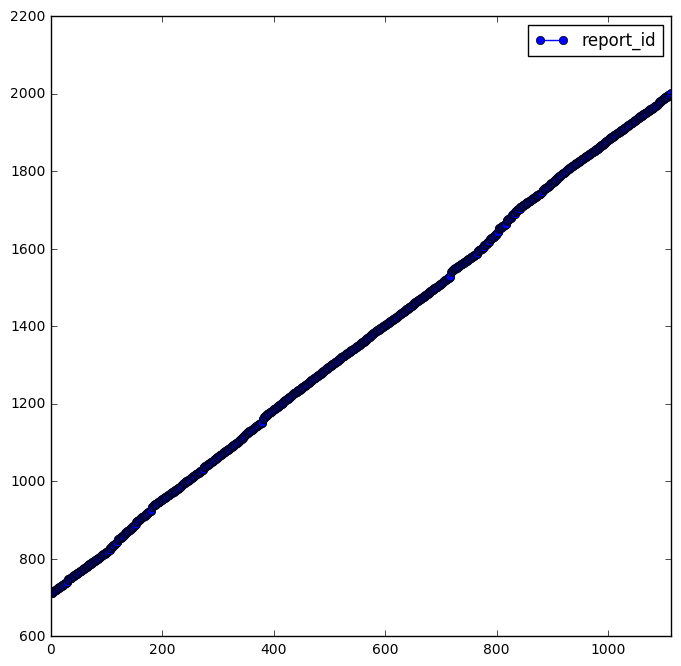

In [439]:
pd.read_sql_query('select report_id from reports order by report_id', engine).plot(style='o-')

# Get new days of data

to do!

# plotting

In [255]:
%matplotlib inline

In [320]:
import matplotlib.pyplot as plt

plt.rc('savefig', dpi=100)
plt.rc('figure', figsize=(8,8))

In [256]:
ratings = ['No Rating', 'Low', 'Moderate', 'Considerable', 'High', 'Extreme']
colors = ['gray', 'green', 'yellow', 'orange', 'red', 'black']
coldict = {rating:color for rating, color in zip(ratings, colors)}
coldict

{'Considerable': 'orange',
 'Extreme': 'black',
 'High': 'red',
 'Low': 'green',
 'Moderate': 'yellow',
 'No Rating': 'gray'}

In [269]:
ratdict = {rat:i for i,rat in enumerate(ratings)}

In [382]:
from matplotlib.patches import Rectangle
from matplotlib.dates import date2num, num2date

def color_timeline(data, ymin=0, dy=1, ax=None):
    if ax is None:
        ax = plt.gca()
    for stamp,danger in data.iteritems():
        #start = date2num(stamp)
        start = date2num(stamp)
        color = coldict.get(danger, 'm') # magenta for unknown (probably null) values
        r = Rectangle((start, ymin), 1, dy, fc=color, ec='w')
        ax.add_patch(r)

In [369]:
len(df)

139

In [374]:
pd.read_sql_query('select distinct treeline_above from reports', engine)

,treeline_above
0,None
1,Moderate
2,High
3,Low
4,Considerable


In [436]:
def snow_year(year):
    return pd.datetime(year - 1, 11, 1), pd.datetime(year, 7, 1)

def fetch_ratings(range_min, range_max):
    stmt = sa.select([report_table]
                    ).where(
                        report_table.c.region == 'Mt Hood'
                    ).where(
                        report_table.c.datetime_utc <= range_max
                    ).where(
                        report_table.c.datetime_utc >= range_min
                    ).order_by(report_table.c.datetime_utc)

    df = pd.read_sql_query(stmt, engine)
    return df

df = fetch_ratings(*snow_year(2015))
df.head()

,report_id,datetime,datetime_utc,author,region,summary,treeline_above,treeline_near,treeline_below
0,899,"9:36 PM PST Friday, December 19, 2014",2014-12-20 05:36:00,Dennis D'Amico,Mt Hood,The upcoming weekend storm system is expected ...,None,None,None
1,907,"7:02 PM PST Saturday, December 20, 2014",2014-12-21 03:02:00,Kenny Kramer,Mt Hood,The storm over the region Saturday night and S...,None,None,None
2,912,"6:00 PM PST Sunday, December 21, 2014",2014-12-22 02:00:00,Kenny Kramer,Mt Hood,The storm over the region Saturday night and S...,Considerable,Moderate,Moderate
3,920,"6:00 PM PST Monday, December 22, 2014",2014-12-23 02:00:00,Garth Ferber,Mt Hood,Avoid steep previous lee slopes with firmer wi...,Moderate,Moderate,Low
4,926,"6:38 AM PST Tuesday, December 23, 2014",2014-12-23 14:38:00,Garth Ferber,Mt Hood,Avoid steep previous lee slopes with firmer wi...,Moderate,Moderate,Low


In [428]:
def stacked_color_timeline(df, ax=None):
    if ax is None:
        ax = plt.gca()
    color_timeline(df.set_index('datetime_utc')['treeline_above'], ax=ax, ymin=2)
    color_timeline(df.set_index('datetime_utc')['treeline_near'], ax=ax, ymin=1)
    color_timeline(df.set_index('datetime_utc')['treeline_below'], ax=ax)
    ax.set_ylim(0,3)

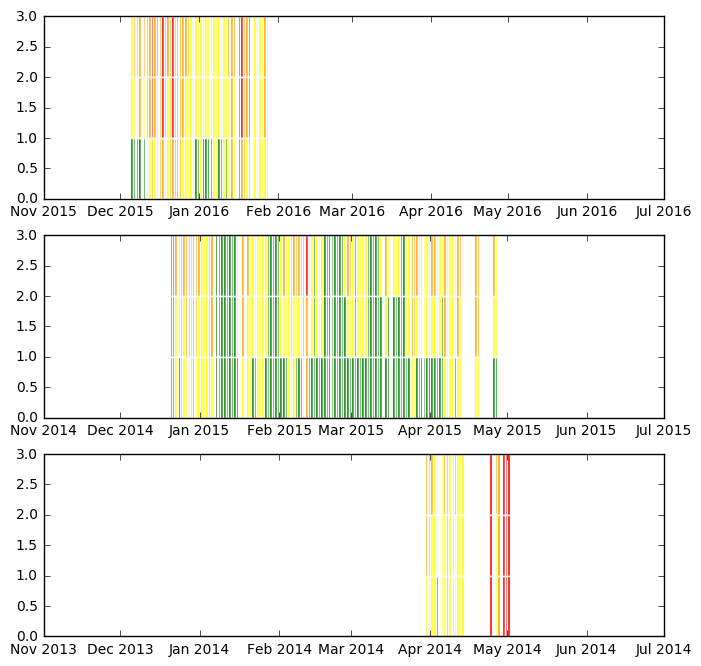

In [437]:
years = (2016, 2015, 2014)

plt.figure(figsize=(12,2))

f,axes = plt.subplots(len(years)) #, sharex=True)
#plt.subplots_adjust(hspace=0)

for ax,year in zip(axes, years):
    drange = snow_year(year)
    df = fetch_ratings(*drange)
    stacked_color_timeline(df, ax=ax)
    ax.set_xlim(drange)
    
#ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
#ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%e %b %y'))


In [324]:
df2 = df.replace({'treeline_above':ratdict,
            'treeline_below':ratdict,
            'treeline_near':ratdict,}
                 ).set_index('datetime_utc')

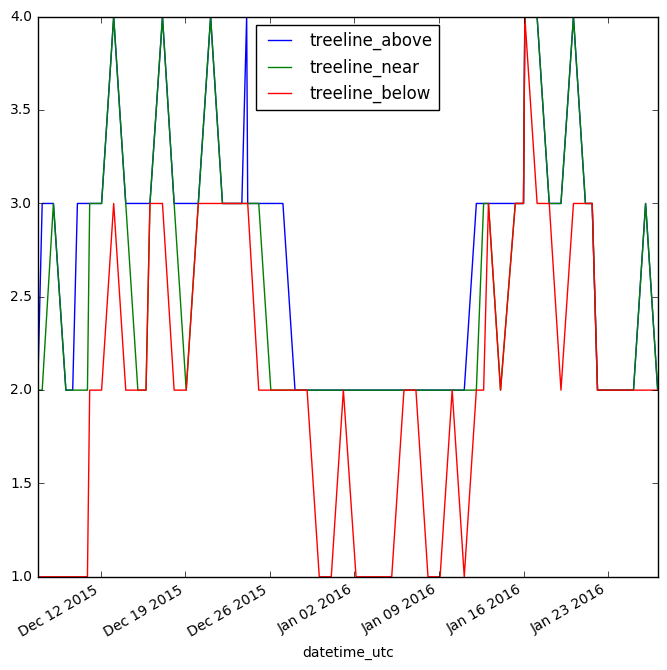

In [325]:
df2[['treeline_above', 'treeline_near', 'treeline_below']].plot()